# Creating a Kaggle Workflow

Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In standard software development, code not working as you expect can be caused by a number of factors along two dimensions:

- Bugs in implementation
- Algorithm design

Machine learning problems, have many more dimensions:

- Bugs in implementation
- Algorithm design
- Model issues
- Data quality

The result of this is that there are exponentially more places that machine learning can go wrong.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [2]:
holdout.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

## Preprocessing the Data

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_data(df):
    """Process data using the functions above

    Usage
    ------

    train = process_data(train)
    """    
    
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df) 
    df = process_titles(df)
    df = process_cabin(df)
    
    dummy_targets = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for target in dummy_targets:
        df = create_dummies(df, target)
    return df

In [4]:
train = process_data(train)
holdout = process_data(holdout)

## Exploring the Data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def draw_distribution(df, column):
    """Draw histogram

    Usage
    ------

    draw_distribution(train, 'SibSp')
    """        
    df.hist(column = column, color="teal")
    plt.title('{} Distribution'.format(column))
    


def draw_survival_chance(df, column): 
    """Draw bar chart on survival chance by criteria 

    Usage
    ------

    draw_survival_chance(train, 'SibSp')
    """       
    df.pivot_table(index = column, values = 'Survived').plot.bar(color = 'teal')

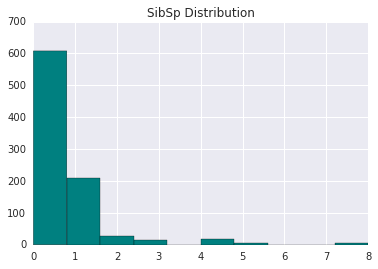

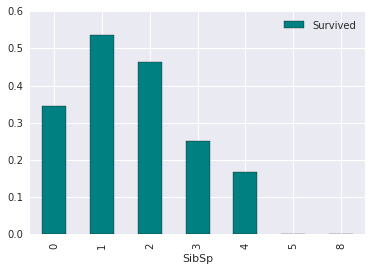

In [6]:
draw_distribution(train, 'SibSp')
draw_survival_chance(train, 'SibSp')

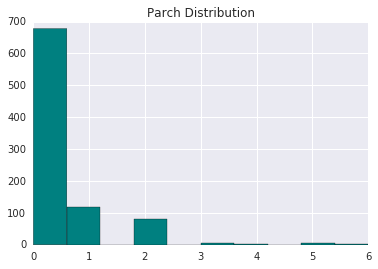

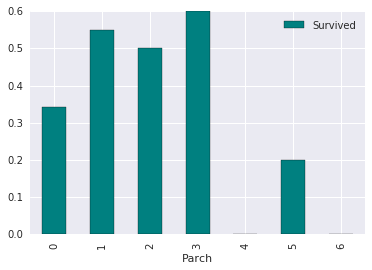

In [7]:
draw_distribution(train, 'Parch')
draw_survival_chance(train, 'Parch')

From the visualization above, we can find two things.

- Most people got on board by themselves
- Peopel with one or two family member more likely survived than other group.  

## Engineering New Features

In [8]:
def create_isalone(df):
    df.loc[(df['SibSp'] + df['Parch']) == 0,'isalone'] = 1
    df.loc[(df['SibSp'] + df['Parch']) != 0,'isalone'] = 0
    return df

In [9]:
train = create_isalone(train)
holdout = create_isalone(holdout)

In [10]:
train

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25            26         1       3   
26            27         0       3   
27            28         0       1   
28            29         1       3   
29            30         0       3   
..           ...       ...     ...   
861          862         0       2   
862          863         1       1   
863          864         0       3   
864          865         0       2   
865          866         1       2   
866          867         1       2   
867          868         0       1   
868          869         0       3   
869          870         1       3   
870          871         0       3   
871          872         1       1   
872          873         0       1   
873          874         0       3   
874          875         1       2   
875          876         1       3   
876          877         0       3   
877          878         0       3   
878          879         0       3   
879          880         1       1   
880          881         1       2   
881          882         0       3   
882          883         0       3   
883          884         0       2   
884          885         0       3   
885          886         0       3   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
5                                     Moran, Mr. James    male  -0.5      0   
6                              McCarthy, Mr. Timothy J    male  54.0      0   
7                       Palsson, Master. Gosta Leonard    male   2.0      3   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                  Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                     Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                            Bonnell, Miss. Elizabeth  female  58.0      0   
12                      Saundercock, Mr. William Henry    male  20.0      0   
13                         Andersson, Mr. Anders Johan    male  39.0      1   
14                Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   
15                    Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
16                                Rice, Master. Eugene    male   2.0      4   
17                        Williams, Mr. Charles Eugene    male  -0.5      0   
18   Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0      1   
19                             Masselmani, Mrs. Fatima  female  -0.5

## Selecting the Best-Performing Features

To speed up our Kaggle workflow, we can create a function that performs this step for us, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

In [39]:
def select_features(df):
    """Select the best features 

    Usage
    ------

    best_features = select_features(df)
    """         
    
    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestClassifier
    columns = df.select_dtypes(include=np.number).columns.drop(['PassengerId','Survived'])
    target = ['Survived']
    all_X = df[columns]
    all_y = df[target]
    rf = RandomForestClassifier(random_state = 1)
    rfecv = RFECV(rf,cv = 10)    
    rfecv.fit(all_X, all_y.values.ravel())
    print(all_X.columns[rfecv.support_])
    return all_X.columns[rfecv.support_]
    

In [38]:
best_features = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms

Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.



In [80]:
def select_model(df, best_features):
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier

    all_X = train[best_features]
    all_y = train['Survived']

    hyperparameters =[
    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    },
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
    },
    {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }        
    }
    ]

    for hyperparameter in hyperparameters:
        print(hyperparameter["name"])
        grid = GridSearchCV(hyperparameter["estimator"],param_grid = hyperparameter["hyperparameters"],cv = 10)
        grid.fit(all_X, all_y)
        hyperparameter['best_parameter'] = grid.best_params_
        hyperparameter['best_score'] = grid.best_score_
        hyperparameter['best_model'] = grid.best_estimator_
    return hyperparameters


In [81]:
hyperparameters = select_model(train, best_features)

KNeighborsClassifier
LogisticRegression
RandomForestClassifier


In [82]:
hyperparameters

[{'best_model': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=1,
             weights='uniform'),
  'best_parameter': {'algorithm': 'brute',
   'n_neighbors': 5,
   'p': 1,
   'weights': 'uniform'},
  'best_score': 0.7755331088664422,
  'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
  'hyperparameters': {'algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'n_neighbors': range(1, 20, 2),
   'p': [1, 2],
   'weights': ['distance', 'uniform']},
  'name': 'KNeighborsClassifier'},
 {'best_model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'best_p

From the result above, the random forest returned the best score. Let's create the function that create submission file.

## Making a Submission to Kaggle

In [83]:
def save_submission_file(model, features, filename = 'submission.csv'):
    _filename = filename
    predictions = model.predict(holdout[features])
    submission_df = {
        'PassengerID': holdout.index,
        'Survived': predictions
    }
    submission = pd.DataFrame(submission_df)
    submission.to_csv(_filename)
    

In [85]:
save_submission_file(hyperparameters[2]['best_model'], best_features)